In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from distortions.geometry import neighborhoods, Geometry, local_distortions, bind_metric
from distortions.visualization import dplot
import numpy as np
import scanpy as sc
import altair as alt

In [2]:
# Read data directly from GitHub
data_url = "https://raw.githubusercontent.com/krisrs1128/distortions-data/main/data/c-elegans_qc_final.txt"
metadata_url = "https://raw.githubusercontent.com/krisrs1128/distortions-data/main/data/c-elegans_qc_final_metadata.txt"

data = np.loadtxt(data_url, delimiter="\t")
metadata = pd.read_csv(metadata_url, sep=",")

print("Data shape:", data.shape)
print("Metadata shape:", metadata.shape)

Data shape: (86024, 100)
Metadata shape: (86024, 15)


In [3]:
# chech min max value of data
print("Data min value:", np.min(data))
print("Data max value:", np.max(data))

Data min value: -20.558958
Data max value: 26.90514


In [4]:
metadata

,Unnamed: 0,cell,n.umi,time.point,batch,Size_Factor,cell.type,cell.subtype,plot.cell.type,raw.embryo.time,embryo.time,embryo.time.bin,raw.embryo.time.bin,lineage,passed_initial_QC_or_later_whitelisted
0,AAACCTGAGACAATAC-300.1.1,AAACCTGAGACAATAC-300.1.1,1630,300_minutes,Waterston_300_minutes,1.023195,Body_wall_muscle,BWM_head_row_1,BWM_head_row_1,360,380.0,330-390,330-390,MSxpappp,True
1,AAACCTGAGGGCTCTC-300.1.1,AAACCTGAGGGCTCTC-300.1.1,2319,300_minutes,Waterston_300_minutes,1.458210,NaN,NaN,NaN,260,220.0,210-270,210-270,MSxapaap,True
2,AAACCTGAGTGCGTGA-300.1.1,AAACCTGAGTGCGTGA-300.1.1,3719,300_minutes,Waterston_300_minutes,2.338283,NaN,NaN,NaN,270,230.0,210-270,270-330,NaN,True
3,AAACCTGAGTTGAGTA-300.1.1,AAACCTGAGTTGAGTA-300.1.1,4251,300_minutes,Waterston_300_minutes,2.659051,Body_wall_muscle,BWM_anterior,BWM_anterior,260,280.0,270-330,210-270,Dxap,True
4,AAACCTGCAAGACGTG-300.1.1,AAACCTGCAAGACGTG-300.1.1,1003,300_minutes,Waterston_300_minutes,0.629610,Ciliated_amphid_neuron,AFD,AFD,350,350.0,330-390,330-390,ABalpppapav/ABpraaaapav,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86019,TCTGAGACATGTCGAT-b02,TCTGAGACATGTCGAT-b02,585,mixed,Murray_b02,0.364709,Rectal_gland,Rectal_gland,Rectal_gland,390,700.0,> 650,390-450,NaN,True
86020,TCTGAGACATGTCTCC-b02,TCTGAGACATGTCTCC-b02,510,mixed,Murray_b02,0.323907,NaN,NaN,NaN,510,470.0,450-510,510-580,NaN,True
86021,TGGCCAGCACGAAGCA-b02,TGGCCAGCACGAAGCA-b02,843,mixed,Murray_b02,0.529174,NaN,NaN,NaN,400,470.0,450-510,390-450,NaN,True
86022,TGGCGCACAGGCAGTA-b02,TGGCGCACAGGCAGTA-b02,636,mixed,Murray_b02,0.397979,NaN,NaN,NaN,330,350.0,330-390,330-390,NaN,True


In [5]:
colors = pd.Categorical(metadata['cell.type']).codes
label_pick = [24, 14, 2, 34]
from collections import defaultdict

def sampling(source, num_sample, label_pick):    
    class_indices = defaultdict(list)
    for idx, label in enumerate(source):
        class_indices[label].append(idx)

    # Randomly sample points from each class
    rng = np.random.default_rng(seed=42)  # Set a seed for reproducibility
    sampled_indices = []
    for label, indices in class_indices.items():
        if label in label_pick:
            n_class_samples = min(len(indices), num_sample)  # Equal sampling
            sampled_indices.extend(rng.choice(indices, n_class_samples, replace=False))
    return sampled_indices

sampled_indices = sampling(colors, 1000, label_pick)

In [6]:
from scipy.spatial import KDTree
import os

cache_file = "data/c_elegans_distances.npy"
if os.path.exists(cache_file):
    dists = np.load(cache_file)
else:
    tree = KDTree(data)
    dists, _ = tree.query(data, k=3)
    os.makedirs("data", exist_ok=True)
    np.save(cache_file, dists)

In [7]:
n_neighbors = 10
radius = 3 * np.mean(dists)
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": 5})

## UMAP and DenseUmap

In [8]:
# set random seed for reproducibility
np.random.seed(42)
import umap
embedding_dumap = umap.UMAP(n_neighbors=10, n_components=2, n_epochs=500, densmap = True).fit_transform(data)
embedding_umap = umap.UMAP(n_neighbors=10, n_components=2, n_epochs=500, densmap = False).fit_transform(data)

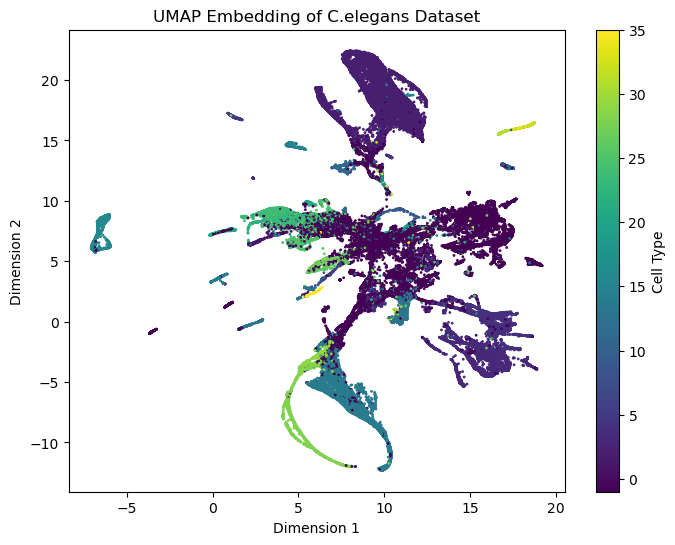

In [9]:
plt.figure(figsize=(8, 6))
fig_umpa =plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], 
            c=pd.Categorical(metadata['cell.type']).codes, cmap='viridis', s=1)
plt.colorbar(fig_umpa, label='Cell Type')
plt.title("UMAP Embedding of C.elegans Dataset")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

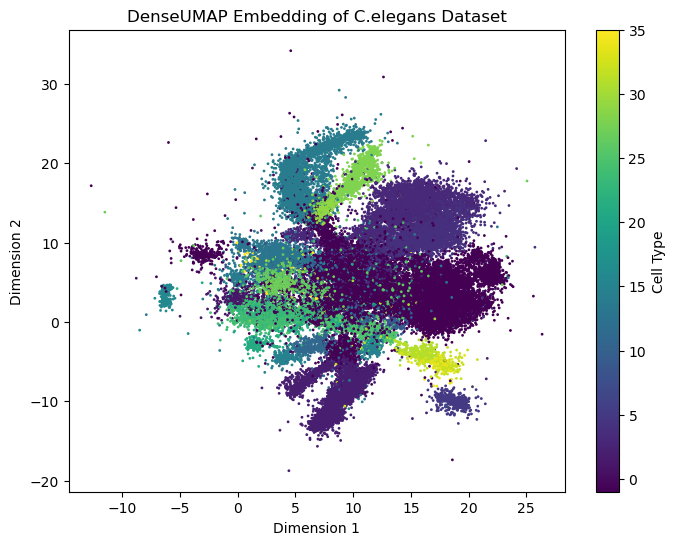

In [10]:
plt.figure(figsize=(8, 6))
fig_umpa =plt.scatter(embedding_dumap[:, 0], embedding_dumap[:, 1], 
            c=pd.Categorical(metadata['cell.type']).codes, cmap='viridis', s=1)
plt.colorbar(fig_umpa, label='Cell Type')
plt.title("DenseUMAP Embedding of C.elegans Dataset")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [11]:
# transfer a numpy data to anndata
import anndata as ad
adata = ad.AnnData(X=data[sampled_indices])
adata.X.shape
adata.obsm["X_UMAP"] = embedding_umap[sampled_indices]
adata.obsm["X_DenseUMAP"] = embedding_dumap[sampled_indices]
adata.obs["cell_type"] = metadata['cell.type'].values[sampled_indices]
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=40, method='gauss')

In [12]:
umap_embed_test = adata.obsm["X_UMAP"].copy()
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": radius})
H, Hvv, Hs = local_distortions(umap_embed_test, adata.X, geom)
umap_embed_test = bind_metric(umap_embed_test, Hvv, Hs)
umap_embed_test["cell_type"] = adata.obs["cell_type"].values

In [13]:
N = neighborhoods(adata, threshold=.2, outlier_factor=2, method="box", embed_key="X_UMAP")
dplot(umap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
    .geom_ellipse(radiusMax=8, radiusMin=2)\
    .scale_color(legendTextSize=8)\
    .labs(x="UMAP 1", y="UMAP 2")\
    .inter_edge_link(N=N, threshold=1, backgroundOpacity=0.4, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=0.1)

dplot(dataset=[{'embedding_0': 10.636955261230469, 'embedding_1': 18.214107513427734, 'x0': -0.998865286620071…

In [14]:
from distortions.geometry import Geometry, bind_metric, local_distortions
dumap_embed_test = adata.obsm["X_DenseUMAP"].copy()
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": radius})
H, Hvv, Hs = local_distortions(dumap_embed_test, adata.X, geom)
dumap_embed_test = bind_metric(dumap_embed_test, Hvv, Hs)
dumap_embed_test["cell_type"] = adata.obs["cell_type"].values

In [15]:
N = neighborhoods(adata, threshold=.02, outlier_factor=2, method="box", embed_key="X_UMAP")
dplot(dumap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
    .geom_ellipse()\
    .scale_color(legendTextSize=8)\
    .labs(x="DenseUMAP 1", y="DenseUMAP 2")\
    .inter_edge_link(N=N, threshold=1, backgroundOpacity=0.4, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=0.1)

dplot(dataset=[{'embedding_0': 9.927645683288574, 'embedding_1': -8.331454277038574, 'x0': -0.968463598100212,…

In [16]:
from distortions.geometry.neighborhoods import broken_knn, neighbor_generator

brokens = broken_knn(adata.obsm['X_UMAP'], k=5, z_thresh=2.0) # after I found the broken points
broken_neighbors = neighbor_generator(embedding_umap, [sampled_indices[i] for i in brokens], number_neighbor=10) # generate neighbor dict
broken_neighbors

{73596: [4790, 20777, 20592, 34552, 69932, 20679, 11239, 23261, 12437, 20814],
 57113: [50740, 56052, 55824, 53409, 55883, 56289, 56291, 58650, 48031, 44480],
 69022: [76169, 59019, 84128, 43318, 42690, 83836, 82810, 67851, 31736, 83955],
 79172: [46841, 66448, 33095, 48760, 47431, 41317, 73999, 49526, 63919, 50035],
 71449: [32523, 47674, 65961, 60491, 62498, 13213, 75565, 71256, 76123, 49298],
 59924: [21397, 39275, 57965, 63187, 24867, 59895, 10637, 24850, 68423, 67306],
 64777: [13451, 23890, 6839, 32386, 18627, 17142, 19383, 23016, 31263, 5605],
 80834: [77493, 68701, 85706, 80412, 85578, 85757, 85647, 68668, 85769, 85826],
 70453: [817, 12541, 14284, 76336, 74305, 77080, 60713, 10751, 18440, 30693],
 75236: [60542, 780, 10798, 22846, 30778, 27245, 26109, 2079, 76429, 30503],
 68059: [62136, 66227, 70784, 62867, 78662, 72500, 64976, 66587, 70216, 63369],
 62722: [62919, 65028, 62264, 62429, 62725, 77038, 80216, 61650, 70985, 62765],
 61274: [65389, 68249, 65212, 70852, 65520, 6592

In [17]:
#broken_neighbors[52388]
broken_neighbors[57113]

[50740, 56052, 55824, 53409, 55883, 56289, 56291, 58650, 48031, 44480]

In [18]:
#point = 52388
point = 57113
adata_add = ad.AnnData(X=data[sampled_indices+ broken_neighbors[point]])
adata_add.obsm["X_DUMAP"] = embedding_umap[sampled_indices + broken_neighbors[point]]

In [19]:
from distortions.visualization import dplot
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": radius})
H, Hvv, Hs = local_distortions(adata.obsm['X_DenseUMAP'], adata.X, geom)
embedding_test_1 = bind_metric(embedding_umap[sampled_indices], Hvv, Hs)
embedding_test_1["cell_type"] = pd.Categorical(metadata['cell.type'])[sampled_indices]
metrics = {k: H[k] for k in range(len(H))}
dplot(embedding_test_1, width=900, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_ellipse()\
    .inter_isometry(metrics=metrics, metric_bw=3, transformation_bw=1)\
    .scale_color()\
    .labs(x="x-axis", y="y-axis")

dplot(dataset=[{'embedding_0': 10.636955261230469, 'embedding_1': 18.214107513427734, 'x0': -0.968463598100212…

In [20]:
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": 5})
H, Hvv, Hs = local_distortions(adata_add.obsm["X_DUMAP"], adata_add.X, geom)
embedding_test_2 = bind_metric(embedding_dumap[sampled_indices + broken_neighbors[point]], Hvv, Hs)
embedding_test_2["cell_type"] = pd.Categorical(metadata['cell.type'])[sampled_indices + broken_neighbors[point]]
metrics = {k: H[k] for k in range(len(H))}
dplot(embedding_test_2, width=900, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_ellipse()\
    .inter_isometry(metrics=metrics, metric_bw=3, transformation_bw=1)\
    .scale_color()\
    .labs(x="x-axis", y="y-axis")

dplot(dataset=[{'embedding_0': 9.927645683288574, 'embedding_1': -8.331454277038574, 'x0': -0.9988652866200365…

In [21]:
dplot(embedding_test_1, width=700, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_hair(radiusMin=1, radiusMax=20)\
    .scale_color(legendTextSize=7)\
    .labs(x="UMAP-x", y="UMAP-y")

dplot(dataset=[{'embedding_0': 10.636955261230469, 'embedding_1': 18.214107513427734, 'x0': -0.968463598100212…

In [22]:
dplot(embedding_test_2, width=700, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_hair()\
    .scale_color(legendTextSize=7)\
    .labs(x="DensMAP-x", y="DensMAP-y")

dplot(dataset=[{'embedding_0': 9.927645683288574, 'embedding_1': -8.331454277038574, 'x0': -0.9988652866200365…

In [23]:
rng = np.random.default_rng(seed=42)

cell_types = metadata['cell.type'].dropna().unique()
selected_types = rng.choice(cell_types, size=10, replace=False)

n_per_type = 5000
random_indices = []
for ct in selected_types:
    idx = metadata.index[metadata['cell.type'] == ct].to_numpy()
    k = min(len(idx), n_per_type)
    random_indices.extend(rng.choice(idx, size=k, replace=False).tolist())


adata_random = ad.AnnData(X=data[random_indices])
adata_random.obsm["X_UMAP"] = embedding_umap[random_indices]
adata_random.obsm["X_UMAP"][:, 1] = -adata_random.obsm["X_UMAP"][:, 1]
adata_random.obsm["X_UMAP"]

adata_random.obsm["X_DenseUMAP"] = embedding_dumap[random_indices]
adata_random.obs["cell_type"] = metadata['cell.type'].values[random_indices]
sc.pp.neighbors(adata_random, n_neighbors=50, n_pcs=40, method='gauss')

In [24]:
selected_types

array(['Arcade_cell', 'Glia', 'Pharyngeal_neuron',
       'Intestinal_and_rectal_muscle', 'Pharyngeal_marginal_cell',
       'M_cell', 'Excretory_duct_and_pore', 'Hypodermis', 'Intestine',
       'Rectal_gland'], dtype=object)

In [25]:
umap_embed_test = adata_random.obsm["X_UMAP"].copy()
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": 2})
H, Hvv, Hs = local_distortions(umap_embed_test, adata_random.X, geom)
umap_embed_test = bind_metric(umap_embed_test, Hvv, Hs)
umap_embed_test["cell_type"] = adata_random.obs["cell_type"].values
summary = {"umap_kappa": Hs[:, 0] / Hs[:, 1], "umap_vol": Hs[:, 0] * Hs[:, 1]}

plots = {}
N = {
    "UMAP": neighborhoods(adata_random, threshold=.4, outlier_factor=3, embed_key="X_UMAP"),
    "DensMAP": neighborhoods(adata_random, threshold=.4, outlier_factor=3, embed_key="X_DenseUMAP")
}

plots["UMAP_p"] = dplot(umap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
    .geom_ellipse(radiusMin=1, radiusMax=20)\
    .scale_color(legendTextSize=8)\
    .labs(x="UMAP 1", y="UMAP 2")\
    .inter_edge_link(N=N["UMAP"], threshold=1, backgroundOpacity=0.3, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=1)

In [26]:
dumap_embed_test = adata_random.obsm["X_DenseUMAP"].copy()
geom = Geometry("brute", laplacian_method="geometric", affinity_kwds={"radius": radius}, adjacency_kwds={"n_neighbors": n_neighbors}, laplacian_kwds={"scaling_epps": 2})
H, Hvv, Hs = local_distortions(dumap_embed_test, adata_random.X, geom)
dumap_embed_test = bind_metric(dumap_embed_test, Hvv, Hs)
dumap_embed_test["cell_type"] = adata_random.obs["cell_type"].values
plots["DensMAP_p"] = dplot(dumap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", color="cell_type")\
    .geom_ellipse(radiusMin=1, radiusMax=20)\
    .scale_color(legendTextSize=8)\
    .labs(x="DensMAP 1", y="DensMAP 2")\
    .inter_edge_link(N=N["DensMAP"], threshold=1, backgroundOpacity=0.3, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=1)

In [27]:
metrics = {k: H[k] for k in range(len(H))}
plots["normal_hair"] = dplot(umap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_hair(radiusMin=1)\
    .scale_color(legendTextSize=7)\
    .labs(x="UMAP 1", y="UMAP 2")\
    .inter_edge_link(N=N["UMAP"], threshold=1, backgroundOpacity=0.3, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=1, otherClasses=["hair"])

In [28]:
plots["dense_hair"] = dplot(dumap_embed_test, width=600, height=500)\
    .mapping(x="embedding_0", y="embedding_1", angle="angle", a="s0", b="s1", color="cell_type")\
    .geom_hair(radiusMin=1)\
    .scale_color(legendTextSize=8)\
    .labs(x="DensMAP 1", y="DensMAP 2")\
    .inter_edge_link(N=N["DensMAP"], threshold=1, backgroundOpacity=0.3, strokeWidth=0.1, strokeOpacity=1, highlightStrokeWidth=1, otherClasses=["hair"])

In [29]:
summary["densmap_kappa"] = Hs[:, 0] / Hs[:, 1]
summary["densmap_vol"] = Hs[:, 0] * Hs[:, 1]
df_kappa = pd.concat([
    pd.DataFrame({'ratio': np.log(summary["umap_kappa"]), 'method': 'umap', 'cell_type': adata_random.obs['cell_type']}),
    pd.DataFrame({'ratio': np.log(summary["densmap_kappa"]), 'method': 'densmap'})
])

kappa_p = alt.Chart(df_kappa).mark_bar(opacity=0.8).encode(
    x=alt.X('ratio', bin=alt.Bin(maxbins=50), title=""),
    y=alt.Y('count()', stack=None),
    color=alt.Color('method:N', legend=alt.Legend(title="Method"))
).properties(width=400, height=300)
#kappa_p.save("../../paper/figures/kappa_p.svg")

In [35]:
[p.save(f"{k}.svg") for k, p in plots.items()]

[None, None, None, None]

In [36]:
[display(p) for p in plots.values()]

dplot(dataset=[{'embedding_0': 2.621859312057495, 'embedding_1': -6.672133445739746, 'x0': -0.8586917522648949…

dplot(dataset=[{'embedding_0': -0.2700165808200836, 'embedding_1': 2.211699962615967, 'x0': -0.157491850843188…

dplot(dataset=[{'embedding_0': 2.621859312057495, 'embedding_1': -6.672133445739746, 'x0': -0.8586917522648949…

dplot(dataset=[{'embedding_0': -0.2700165808200836, 'embedding_1': 2.211699962615967, 'x0': -0.157491850843188…

[None, None, None, None]

In [32]:
from tqdm.notebook import tqdm

thresholds = np.arange(0.05, 1.0, 0.05)
num_keys = {"UMAP": [], "DensMAP": []}

for t in tqdm(thresholds, desc="Calculating neighborhood sizes..."):
    N_umap = neighborhoods(adata_random, threshold=t, outlier_factor=3, embed_key="X_UMAP")
    N_densmap = neighborhoods(adata_random, threshold=t, outlier_factor=3, embed_key="X_DenseUMAP")
    num_keys["UMAP"].append(len(N_umap))
    num_keys["DensMAP"].append(len(N_densmap))

Calculating neighborhood sizes...:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
distortion_size = alt.Chart(
    pd.DataFrame({
        "threshold": np.tile(np.round(thresholds, 2), 2),
        "Method": np.concatenate([["UMAP"] * len(thresholds), ["DensMAP"] * len(thresholds)]),
        "Count": np.concatenate([num_keys["UMAP"], num_keys["DensMAP"]])
        })
    ).mark_bar().encode(
        x=alt.X("threshold:N", title="Threshold Fraction"),
        y=alt.Y("Count:Q", title="Number of Distorted Neighborhoods"),
        color=alt.Color("Method:N", title="Method")
    )

#distortion_size.save("../../paper/figures/distortion_size.svg")